# introduction to the vectorizing principle

## part 8: window functions

The core of the vectorizing principle is treating rows separately. In this part, we look on 
window functions which still produce an output row for every input row, but can use values from surrounding rows in a defined ordering.

#### the following code shows window function calls in different libraries:


In [6]:
import pandas as pd
import polars as pl
import sqlalchemy as sa
import ibis
from ibis import _ as col
import pydiverse.transform as pdt
from pydiverse.pipedag import Flow, Stage, Table, materialize
from pydiverse.transform import λ
from pydiverse.transform.core.functions import row_number
from pydiverse.transform.core.verbs import (
    mutate, alias, arrange, build_query,
)
from pydiverse.transform.eager import PandasTableImpl
from pydiverse.transform.lazy import SQLTableImpl


@materialize(input_type=pd.DataFrame, version="win1.0.0")
def task_pandas(titanic: pd.DataFrame):
    titanic.sort_values("fare", inplace=True)
    return (
        titanic
        .assign(idx=range(len(titanic)), diff_price=titanic.fare.diff())
    )


@materialize(input_type=pl.DataFrame, version="win1.0.0")
def task_polars(titanic: pl.DataFrame):
    return (
        titanic.sort("fare")
        .with_columns(idx=pl.Series(range(len(titanic))), diff_price=pl.col("fare").diff())
    )


@materialize(input_type=PandasTableImpl, version="win1.0.1")
def task_transform_df(titanic: pdt.Table):
    return (
        titanic
        >> mutate(
            idx=row_number(arrange=[λ.fare]),
            diff_price = λ.fare.shift(-1, arrange=[λ.fare])-λ.fare
        )
        >> arrange(λ.fare)
        >> alias("transform_df")
    )


@materialize(input_type=SQLTableImpl, lazy=True)
def task_transform_sql(titanic: pdt.Table):
    return (
        titanic
        >> mutate(
            idx=row_number(arrange=[λ.fare]),
            diff_price = λ.fare.shift(-1, arrange=[λ.fare])-λ.fare
        )
        >> arrange(λ.fare)
        >> alias("transform_sql")
    )


@materialize(input_type=ibis.api.Table, lazy=True)
def task_ibis(titanic: ibis.api.Table):
    w = ibis.window(order_by=col.fare)
    return (
        titanic
        .mutate(idx=ibis.row_number().over(w), diff_price=col.fare.lag(-1).over(w) - col.fare)
        .order_by(col.fare)
    )


@materialize(input_type=sa.Table, lazy=True)
def task_sqlalchemy(titanic: sa.Table):
    return sa.select(
        titanic,
        sa.func.row_number().over(order_by=titanic.c.fare).label("idx"),
        (sa.func.lead(titanic.c.fare, 1, None).over(order_by=titanic.c.fare)
            - titanic.c.fare).label("diff_price"),
    ).select_from(titanic).order_by(titanic.c.fare)


@materialize(input_type=sa.Table, lazy=True)
def task_sql(titanic: sa.Table):
    return sa.text(f"""
        SELECT tt.*,
               ROW_NUMBER()      OVER (ORDER BY tt.fare ASC NULLS LAST) AS idx,
               LEAD(tt.fare, 1, NULL) OVER (ORDER BY tt.fare ASC NULLS LAST)
                - tt.fare AS diff_price
        FROM {titanic.original.schema}.{titanic.name} AS tt
        ORDER BY tt.fare
    """)

#### define remaining tasks and helper functions

In [7]:
@materialize(version="1.0.0")
def read_input_data():
    titanic = pd.read_csv(
        'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'
    )
    return Table(titanic, name="titanic")


@materialize(input_type=pd.DataFrame)
def print_tables(tbls: list[pd.DataFrame]):
    from matplotlib import pyplot as plt
    fix, axs = plt.subplots(nrows=4, ncols=2)
    for tbl, ax in zip(tbls, axs.flatten()):
        tbl.sort_values("idx", inplace=True)
        print(f"\n\n{tbl}")
        ax.plot(tbl.idx, tbl.diff_price.fillna(0))
        # limit y axis to 30
        ax.set_ylim(0, 30)
    plt.show()


def get_pipeline():
    tasks = [task_pandas, task_polars, task_transform_df, task_transform_sql,
             task_ibis, task_sqlalchemy, task_sql]
    with Flow("flow") as flow:
        with Stage("t1_raw_input"):
            titanic = read_input_data()

        with Stage("t2_transformed_data"):
            out_tbls = [task(titanic) for task in tasks]
            print_tables(out_tbls)

    return flow

#### define pipeline:

In [8]:
def get_pipeline():
    tasks = [task_pandas, task_polars, task_transform_df, task_transform_sql,
             task_ibis, task_sqlalchemy, task_sql]
    with Flow("flow") as flow:
        with Stage("t1_raw_input"):
            titanic = read_input_data()

        with Stage("t2_transformed_data"):
            out_tbls = [task(titanic) for task in tasks]
            print_tables(out_tbls)

    return flow

#### setup logging:

In [9]:
import logging
from pydiverse.pipedag.util.structlog import setup_logging
setup_logging(log_level=logging.INFO)

#### run pipeline:

2023-08-17 19:29:42.548680 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-17 19:29:42.553245 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:42553
2023-08-17 19:29:42.558624 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-17 19:29:42.573740 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2023-08-17 19:29:42.585854 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS t1_raw_input
2023-08-17 19:29:42.587182 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP SCHEMA IF EXISTS t1_raw_input__even CASCADE
2023-08-17 19:29:42.591110 [info     ] Executing sql                  [Duc



     survived  pclass     sex   age  sibsp  parch      fare embarked   class  \
815         0       1    male  <NA>      0      0       0.0        S   First   
822         0       1    male  38.0      0      0       0.0        S   First   
481         0       2    male  <NA>      0      0       0.0        S  Second   
466         0       2    male  <NA>      0      0       0.0        S  Second   
263         0       1    male  40.0      0      0       0.0        S   First   
..        ...     ...     ...   ...    ...    ...       ...      ...     ...   
341         1       1  female  24.0      3      2     263.0        S   First   
88          1       1  female  23.0      3      2     263.0        S   First   
737         1       1    male  35.0      0      0  512.3292        C   First   
679         1       1    male  36.0      0      1  512.3292        C   First   
258         1       1  female  35.0      0      0  512.3292        C   First   

       who  adult_male  deck  embark_

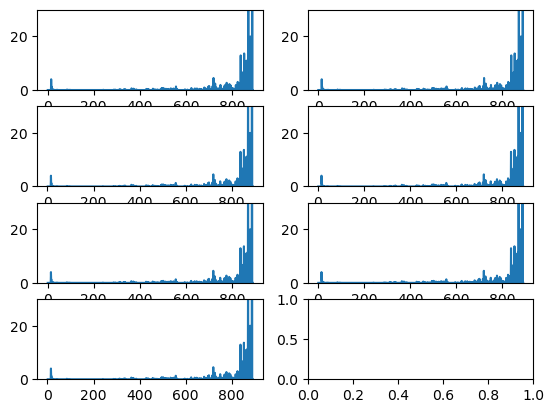

2023-08-17 19:29:45.298125 [info     ] Task finished successfully     [Task 'print_tables'] state=<FinalTaskState.COMPLETED: 1> task=<Task 'print_tables' 0x7f7f53f2be80 (id: 9)>
2023-08-17 19:29:45.300667 [info     ] Committing stage               [Commit Stage] stage=<Stage: t2_transformed_data>
2023-08-17 19:29:45.315091 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP VIEW t2_transformed_data.task_pandas_knng4lw75uvluken764b_0000
2023-08-17 19:29:45.316963 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP VIEW t2_transformed_data.task_polars_yr2b4t44onqdejzgmsom_0000
2023-08-17 19:29:45.318312 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP VIEW t2_transformed_data.transform_df
2023-08-17 19:29:45.319428 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP VIEW t2_transformed_data.transform_sql
2023-08-17 19:29:45.320345 [info     ] Executing sql   

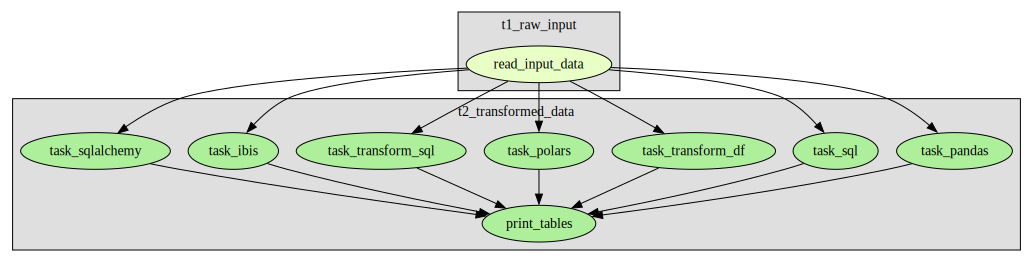

In [10]:
flow = get_pipeline()
result = flow.run()
result.visualize()
assert result.successful